In [ ]:
!pip install --quiet librosa soundfile
!git clone --quiet https://github.com/karoldvl/ESC-50.git

fatal: destination path 'ESC-50' already exists and is not an empty directory.


In [ ]:
# We are using tensorflow because it fits with the selected model

import tensorflow as tf
import tensorflow_hub as hub

import librosa
import numpy as np
import soundfile as sf
import os
import pandas as pd

# schdeuled learning rate
optim = tf.keras.optimizers.Adam(.01, clipnorm=.9)



In [ ]:
class ComplexDense(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super().__init__(**kwargs)
        self.real__dense = tf.keras.layers.Dense(
            units,
            kernel_initializer="glorot_uniform",
            bias_initializer="zeros", **kwargs
        )
        self.imag__dense = tf.keras.layers.Dense(
            units,
            kernel_initializer=tf.keras.initializers.RandomNormal(stddev=1e-3),
            bias_initializer="zeros", **kwargs
        )
    def call(self, inputs):
        real = self.real__dense(inputs)
        imag = self.imag__dense(inputs)
        return tf.complex(real, imag)



meta = pd.read_csv("ESC-50/meta/esc50.csv")
file_paths = meta["filename"].apply(lambda f: os.path.join("ESC-50/audio", f)).tolist()
labels     = meta["category"].astype("category").cat.codes.values
num_classes = meta["category"].nunique()

print("min label:", labels.min(), " max label:", labels.max())
print("num_classes:", num_classes)

min label: 0  max label: 49
num_classes: 50


In [ ]:
# ⚙️ Cell: Build tf.data pipeline (fixed path handling) ─────────────────────
SR = 16000
DURATION = 5.0
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 32

import numpy as np

def load_and_preprocess(path, label):
    # `path` here is a numpy bytes_ or str, not a tf.Tensor
    # Decode it to a Python string:
    if isinstance(path, bytes):
        audio_path = path.decode("utf-8")
    elif isinstance(path, np.bytes_):
        audio_path = path.tobytes().decode("utf-8")
    else:
        audio_path = str(path)
    # Load & resample
    wav, _ = librosa.load(audio_path, sr=SR, mono=True, duration=DURATION)
    target_len = int(SR * DURATION)
    if len(wav) < target_len:
        wav = np.pad(wav, (0, target_len - len(wav)))
    else:
        wav = wav[:target_len]
    # Normalize to [-1,1]
    wav = wav.astype(np.float32)
    wav = wav / (np.max(np.abs(wav)) + 1e-9)
    # Return waveform and label (as numpy types)
    return wav, np.int64(label)

def tf_preprocess(path, label):
    wav, lbl = tf.numpy_function(
        func=load_and_preprocess,
        inp=[path, label],
        Tout=[tf.float32, tf.int64]
    )
    # Tell TF the shapes
    wav.set_shape([int(SR * DURATION)])
    lbl.set_shape([])
    return wav, lbl

# Build the Dataset
ds = (
    tf.data.Dataset
      .from_tensor_slices((file_paths, labels))
      .shuffle(len(file_paths))
      .map(tf_preprocess, num_parallel_calls=AUTOTUNE)
      .batch(BATCH_SIZE)
      .prefetch(AUTOTUNE)
)

# Sanity check
waveforms, lbls = next(iter(ds.take(1)))
print("Waveforms:", waveforms.shape,
      "min/max:", waveforms.numpy().min(), waveforms.numpy().max())
print("Labels:", lbls.shape, "unique:", np.unique(lbls.numpy()))


Waveforms: (32, 80000) min/max: -1.0 1.0
Labels: (32,) unique: [ 2  3  4  5  6  8 10 11 17 21 22 26 32 34 35 37 38 40 42 43 45 47 49]


In [ ]:
yamnet_saved=hub.load("https://tfhub.dev/google/yamnet/1")


def extract_embeds(wavs):
    # wavs: [batch, 80000]
    def embed_one(wav):
        # yamnet_saved(wav) → (scores, embeddings [frames,1024], spec)
        _, emb, _ = yamnet_saved(wav)
        return emb
    # Map over the batch to get [batch, frames, 1024]
    embs = tf.map_fn(
        embed_one,
        wavs,
        fn_output_signature=tf.TensorSpec((None, 1024), tf.float32)
    )
    # Freeze backbone
    return tf.stop_gradient(embs)




In [ ]:
num_classes = 50
wav_in  = tf.keras.Input(shape=(int(SR*DURATION),), dtype=tf.float32, name="waveform")
emb_seq = tf.keras.layers.Lambda(
    extract_embeds,
    output_shape=(None, 1024),
    name="yamnet_embed"
)(wav_in)


pooled  = tf.keras.layers.GlobalAveragePooling1D(name="avg_pool")(emb_seq)  # [batch,1024]
normed  = tf.keras.layers.LayerNormalization(name="ln_embed")(pooled)       # [batch,1024]



cplx    = ComplexDense(256, name="complex_fc")(normed)
                    # [batch,256] complex64

real_part = tf.keras.layers.Lambda(lambda z: tf.math.real(z), name="real_part")(cplx)
imag_part = tf.keras.layers.Lambda(lambda z: tf.math.imag(z), name="imag_part")(cplx)

real_bn = tf.keras.layers.BatchNormalization(name="bn_real")(real_part)
imag_bn = tf.keras.layers.BatchNormalization(name="bn_imag")(imag_part)

real_rl = tf.keras.layers.Activation("relu", name="relu_real")(real_bn)
imag_rl = tf.keras.layers.Activation("relu", name="relu_imag")(imag_bn)

x       = tf.keras.layers.Concatenate(name="concat")([real_rl, imag_rl])   # [batch,512]

# 7) Final classifier
logits  = tf.keras.layers.Dense(num_classes, name="classifier")(x)
probs   = tf.keras.layers.Activation("softmax", name="probs")(logits)

complex_model = tf.keras.Model(inputs=wav_in, outputs=probs, name="complex_tl")


complex_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4, clipnorm=1.0),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

complex_model.summary()

Model: "complex_tl"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ waveform            │ (None, 80000)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ yamnet_embed        │ (None, None,      │          0 │ waveform[0][0]    │
│ (Lambda)            │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ avg_pool            │ (None, 1024)      │          0 │ yamnet_embed[0][… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ln_embed            │ (None, 1024)      │      2,048 │ avg_pool[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ complex_fc          │ (None, 256)       │    524,800 │ ln_embed[0][0]    │
│ (ComplexDense)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ real_part (Lambda)  │ (None, 256)       │          0 │ complex_fc[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ imag_part (Lambda)  │ (None, 256)       │          0 │ complex_fc[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_real             │ (None, 256)       │      1,024 │ real_part[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_imag             │ (None, 256)       │      1,024 │ imag_part[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu_real           │ (None, 256)       │          0 │ bn_real[0][0]     │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu_imag           │ (None, 256)       │          0 │ bn_imag[0][0]     │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat              │ (None, 512)       │          0 │ relu_real[0][0],  │
│ (Concatenate)       │                   │            │ relu_imag[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classifier (Dense)  │ (None, 50)        │     25,650 │ concat[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ probs (Activation)  │ (None, 50)        │          0 │ classifier[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 554,546 (2.12 MB)

 Trainable params: 553,522 (2.11 MB)

 Non-trainable params: 1,024 (4.00 KB)

In [ ]:
# tinkering
comp = ComplexDense(256, name="more_layer_complex")(normed)

real_1 = tf.keras.layers.Lambda(lambda z: tf.math.real(z), name="real")(comp)
imag_1 = tf.keras.layers.Lambda(lambda z: tf.math.imag(z), name="imag")(comp)

bn_real = tf.keras.layers.BatchNormalization(name="bn_real")(real_1)
bn_imag = tf.keras.layers.BatchNormalization(name="bn_imag")(imag_1)

r1_real = tf.keras.layers.Activation("relu", name="relu_real")(bn_real)
r1_imag = tf.keras.layers.Activation("relu", name="relu_imag")(bn_imag)

r1_real = tf.keras.layers.multiply([r1_real, r1_imag], name="mul_real")
r1_imag = tf.keras.layers.multiply([r1_imag, r1_imag], name="mul_imag")

xx = tf.keras.layers.Concatenate(name = "concat")([r1_real, r1_imag])
log = tf.keras.layers.Dense(num_classes, name="classifier")(xx)
probs = tf.keras.layers.Activation("softmax", name="probs")(log)

mk2_complex_model = tf.keras.Model(inputs=wav_in, outputs=probs, name="mk2_comp")
mk2_complex_model.compile(
    optimizer = tf.keras.optimizers.Adam(1e-4, clipnorm=1.0),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

mk2_complex_model.summary()

Model: "mk2_comp"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ waveform            │ (None, 80000)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ yamnet_embed        │ (None, None,      │          0 │ waveform[0][0]    │
│ (Lambda)            │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ avg_pool            │ (None, 1024)      │          0 │ yamnet_embed[0][… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ln_embed            │ (None, 1024)      │      2,048 │ avg_pool[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ more_layer_complex  │ (None, 256)       │    524,800 │ ln_embed[0][0]    │
│ (ComplexDense)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ real (Lambda)       │ (None, 256)       │          0 │ more_layer_compl… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ imag (Lambda)       │ (None, 256)       │          0 │ more_layer_compl… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_real             │ (None, 256)       │      1,024 │ real[0][0]        │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_imag             │ (None, 256)       │      1,024 │ imag[0][0]        │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu_real           │ (None, 256)       │          0 │ bn_real[0][0]     │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu_imag           │ (None, 256)       │          0 │ bn_imag[0][0]     │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mul_real (Multiply) │ (None, 256)       │          0 │ relu_real[0][0],  │
│                     │                   │            │ relu_imag[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mul_imag (Multiply) │ (None, 256)       │          0 │ relu_imag[0][0],  │
│                     │                   │            │ relu_imag[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat              │ (None, 512)       │          0 │ mul_real[0][0],   │
│ (Concatenate)       │                   │            │ mul_imag[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classifier (Dense)  │ (None, 50)        │     25,650 │ concat[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ probs (Activation)  │ (None, 50)        │          0 │ classifier[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 554,546 (2.12 MB)

 Trainable params: 553,522 (2.11 MB)

 Non-trainable params: 1,024 (4.00 KB)

In [ ]:
# ─── Cell: Real‑Valued Baseline Model ─────────────────────────────────────
import tensorflow as tf
import tensorflow_hub as hub

# 1) Load YAMNet
yamnet_saved = hub.load("https://tfhub.dev/google/yamnet/1")

# 2) Batch embedding extractor (same as before)
def extract_embeds_real(wavs):
    def one(wav):
        _, emb, _ = yamnet_saved(wav)
        return emb
    embs = tf.map_fn(
        one,
        wavs,
        fn_output_signature=tf.TensorSpec((None,1024), tf.float32)
    )
    return tf.stop_gradient(embs)

# 3) Build the real baseline
SR, DURATION = 16000, 5.0
num_classes = 50

wav_in_r = tf.keras.Input(shape=(int(SR*DURATION),), dtype=tf.float32, name="wav_real")
emb_seq_r = tf.keras.layers.Lambda(
    extract_embeds_real,
    output_shape=(None,1024),
    name="yamnet_embed_real"
)(wav_in_r)

# Pool & normalize
pooled_r = tf.keras.layers.GlobalAveragePooling1D(name="avg_pool_real")(emb_seq_r)
norm_r   = tf.keras.layers.LayerNormalization(name="ln_real")(pooled_r)

# A small real MLP head
x_r      = tf.keras.layers.Dense(512, activation="relu", name="dense_real1")(norm_r)
x_r      = tf.keras.layers.Dropout(0.5, name="dropout_real")(x_r)
logits_r = tf.keras.layers.Dense(num_classes, name="logits_real")(x_r)
probs_r  = tf.keras.layers.Activation("softmax", name="probs_real")(logits_r)

real_model = tf.keras.Model(wav_in_r, probs_r, name="real_tl")
real_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4, clipnorm=1.0),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)
real_model.summary()


Model: "real_tl"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ wav_real (InputLayer)           │ (None, 80000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ yamnet_embed_real (Lambda)      │ (None, None, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ avg_pool_real                   │ (None, 1024)           │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ ln_real (LayerNormalization)    │ (None, 1024)           │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_real1 (Dense)             │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_real (Dropout)          │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ logits_real (Dense)             │ (None, 50)             │        25,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ probs_real (Activation)         │ (None, 50)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 552,498 (2.11 MB)

 Trainable params: 552,498 (2.11 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_complex = complex_model.fit(
    ds,
    epochs=10,
    validation_data=ds.take(10)
)



Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 232ms/step - accuracy: 0.4174 - loss: 2.5901 - val_accuracy: 0.4250 - val_loss: 2.8511
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 150ms/step - accuracy: 0.7535 - loss: 1.0558 - val_accuracy: 0.7281 - val_loss: 2.1342
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 0.8172 - loss: 0.8073 - val_accuracy: 0.7937 - val_loss: 1.5438
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - accuracy: 0.8442 - loss: 0.6918 - val_accuracy: 0.8469 - val_loss: 1.0667
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 141ms/step - accuracy: 0.8620 - loss: 0.6032 - val_accuracy: 0.8344 - val_loss: 0.8906
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 0.8647 - loss: 0.5910 - val_accuracy: 0.9000 - val_loss: 0.6008
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 153ms/step - accuracy: 0.8776 - loss: 0.5397 - val_accuracy: 0.8719 - val_loss: 0.5177
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - accuracy: 0.8739 - loss: 0.5524 - val_accurac

In [ ]:
history_real = real_model.fit(
    ds,
    epochs=10,
    validation_data=ds.take(10)
)


Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 272ms/step - accuracy: 0.0516 - loss: 4.5090 - val_accuracy: 0.4594 - val_loss: 2.5817
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 154ms/step - accuracy: 0.3198 - loss: 2.7740 - val_accuracy: 0.6438 - val_loss: 1.6627
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 152ms/step - accuracy: 0.5140 - loss: 1.9356 - val_accuracy: 0.7344 - val_loss: 1.1627
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 166ms/step - accuracy: 0.6249 - loss: 1.4983 - val_accuracy: 0.7750 - val_loss: 0.9418
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 152ms/step - accuracy: 0.6735 - loss: 1.2196 - val_accuracy: 0.8344 - val_loss: 0.8178
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 210ms/step - accuracy: 0.6962 - loss: 1.1329 - val_accuracy: 0.7875 - val_loss: 0.8067
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 160ms/step - accuracy: 0.7260 - loss: 0.9905 - val_accuracy: 0.8094 - val_loss: 0.7004
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - accuracy: 0.7377 - loss: 0.9362 - val_accur

In [ ]:
ghistory_mk_2 = mk2_complex_model.fit(
    ds,
    epochs=10,
    validation_data=ds.take(10)
)

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 230ms/step - accuracy: 0.5096 - loss: 2.0582 - val_accuracy: 0.6625 - val_loss: 3.6722
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 153ms/step - accuracy: 0.8170 - loss: 0.7296 - val_accuracy: 0.8188 - val_loss: 3.3597
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 153ms/step - accuracy: 0.8588 - loss: 0.5621 - val_accuracy: 0.8438 - val_loss: 2.9340
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 154ms/step - accuracy: 0.8841 - loss: 0.4788 - val_accuracy: 0.8781 - val_loss: 2.2436
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 138ms/step - accuracy: 0.9003 - loss: 0.4187 - val_accuracy: 0.9250 - val_loss: 1.3742
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 138ms/step - accuracy: 0.9098 - loss: 0.3780 - val_accuracy: 0.9531 - val_loss: 0.7174
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 155ms/step - accuracy: 0.9156 - loss: 0.3700 - val_accuracy: 0.9500 - val_loss: 0.4355
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 159ms/step - accuracy: 0.9291 - loss: 0.3063 - val_accur

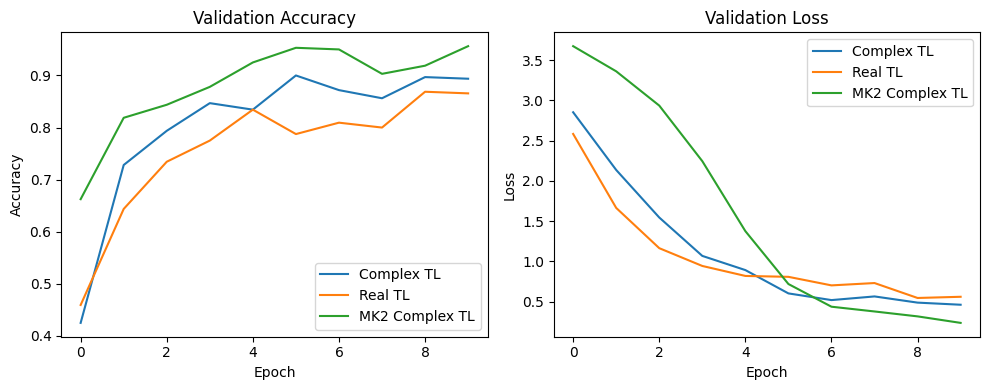

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))

# Val accuracy
plt.subplot(1,2,1)
plt.plot(history_complex.history["val_accuracy"], label="Complex TL")
plt.plot(history_real.history["val_accuracy"],    label="Real TL")
plt.plot(history_mk_2.history["val_accuracy"], label="MK2 Complex TL")
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Val loss
plt.subplot(1,2,2)
plt.plot(history_complex.history["val_loss"], label="Complex TL")
plt.plot(history_real.history["val_loss"],    label="Real TL")
plt.plot(history_mk_2.history["val_loss"], label="MK2 Complex TL")
plt.title("Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()
